In [71]:
import numpy as np
import torch
import torch.nn.functional as F #for one hot encoding
import pandas as pd
from matplotlib import pyplot as plt
import random

In [72]:
words=open("names.txt","r").read().splitlines()

In [4]:
len(words)

32033

In [125]:
chars = sorted(set(''.join(words)))  
chars =['.'] + chars     
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

27


In [6]:
block_size=3
X=[]
Y=[]
for w in words:
    #print(w)
    context=[0]*block_size
    for ch in w +'.':
        ix=stoi[ch]
        Y.append(ix)
        X.append(context)
        #print(''.join(itos[i] for i in context))
        context=context[1:]+[ix]
X=torch.tensor(X)
Y=torch.tensor(Y)

In [7]:
print(X[1])
print(Y[1])
print(X.shape)
print(Y.shape)

tensor([0, 0, 5])
tensor(13)
torch.Size([228146, 3])
torch.Size([228146])


In [19]:
# now we need to embed X for the neural network
C=torch.randn(27,2)
emb=C[X] #yeah we can just do this with pytorch
emb.shape

torch.Size([228146, 3, 2])

In [20]:
W1=torch.randn(6,100) #100 neurons for the first hidden layers
B1=torch.randn(100)

In [21]:
h=torch.tanh(emb.view(-1,6) @ W1 + B1)

In [23]:
h.shape

torch.Size([228146, 100])

In [26]:
W2=torch.randn(100,27)
B2=torch.randn(27)

In [43]:
logits=h @ W2 +B2
'''
count=logits.exp()
probs=count/count.sum(1,keepdim=True)
loss=-probs[torch.arange(len(Y)),Y].log().mean()
'''
loss=F.cross_entropy(logits,Y) 

tensor(15.1216)

In [262]:
# creating training testing and validation dataset
def buildDataset(words):
    block_size=3
    X=[]
    Y=[]
    for w in words:
        #print(w)
        context=[0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            Y.append(ix)
            X.append(context)
            #print(''.join(itos[i] for i in context))
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

random.shuffle(words)
n=int(0.8*len(words))
m=int(0.9*len(words))
Xtrain,Ytrain=buildDataset(words[:n])
XVal,YVal=buildDataset(words[n:m])
Xtest,Ytest=buildDataset(words[m:])

In [263]:
n_emb=10 #dimansionality of each character
n_n=300 #number of neurons
C=torch.randn(len(chars),n_emb) 
W1=torch.randn(n_emb*block_size,n_n) * (5/3) / ((n_emb*block_size)**0.5) #to prevent plateau region of tanh for h
#the above formula is given in the pytorch documentation for standard deviation of tanh 
B1=torch.randn(n_n) * 0.01
W2 = torch.randn(n_n, len(chars)) / np.sqrt(n_n)
B2=torch.randn(len(chars)) * 0

bngain=torch.ones(1,n_n)
bnbais=torch.zeros(1,n_n) #batch normalization parameters 
bnmean_running = torch.zeros(1, n_n)
bnstd_running = torch.ones(1, n_n)

parameters=[C,W1,W2,B1,B2,bngain,bnbais]

In [264]:
for p in parameters:
    p.requires_grad=True

In [265]:
stepi=[]
lossi=[]
lr=0.1
batch_size=60

In [266]:
for i in range(200000): 
    #minibatch
    ix=torch.randint(0,Xtrain.shape[0],(batch_size,)) 
    #forward pass
    emb=C[Xtrain[ix]]
    embcat=emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + B1
    #batch normalization
    batch_mean = hpreact.mean(0, keepdim=True)
    batch_var = hpreact.var(0, unbiased=False, keepdim=True)
    hpreact = bngain * (hpreact - batch_mean) / torch.sqrt(batch_var + 1e-5) + bnbais

    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * batch_mean
        bnstd_running = 0.99 * bnstd_running + 0.01 * batch_var
        
    h=torch.tanh(hpreact)
    logits=h @ W2 +B2
    loss=F.cross_entropy(logits,Ytrain[ix])
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    if i>150000: #step decay learning rate
        lr=0.01
    for p in parameters:
        p.data-=lr*p.grad
    stepi.append(i)
    lossi.append(loss.item())
print("training loss: ",loss.item())

training loss:  2.1476638317108154


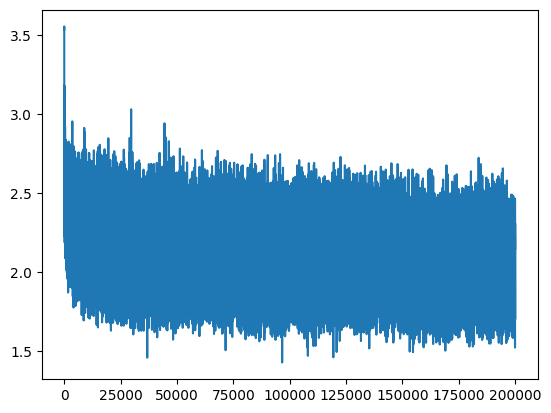

In [267]:
plt.plot(stepi,lossi)

(array([1539.,  663.,  443.,  380.,  329.,  287.,  261.,  246.,  332.,
         247.,  226.,  238.,  182.,  249.,  187.,  255.,  320.,  219.,
         261.,  261.,  302.,  334.,  438.,  337.,  370.,  441.,  442.,
         374.,  441.,  258.,  286.,  306.,  290.,  281.,  246.,  225.,
         191.,  199.,  194.,  215.,  238.,  271.,  273.,  291.,  323.,
         326.,  375.,  469.,  645., 1494.]),
 array([-9.99997914e-01, -9.59998087e-01, -9.19998260e-01, -8.79998432e-01,
        -8.39998605e-01, -7.99998778e-01, -7.59998951e-01, -7.19999124e-01,
        -6.79999297e-01, -6.39999470e-01, -5.99999642e-01, -5.59999815e-01,
        -5.19999988e-01, -4.80000161e-01, -4.40000334e-01, -4.00000507e-01,
        -3.60000679e-01, -3.20000852e-01, -2.80001025e-01, -2.40001198e-01,
        -2.00001371e-01, -1.60001544e-01, -1.20001717e-01, -8.00018895e-02,
        -4.00020623e-02, -2.23517418e-06,  3.99975920e-02,  7.99974191e-02,
         1.19997246e-01,  1.59997073e-01,  1.99996901e-01,  2.399967

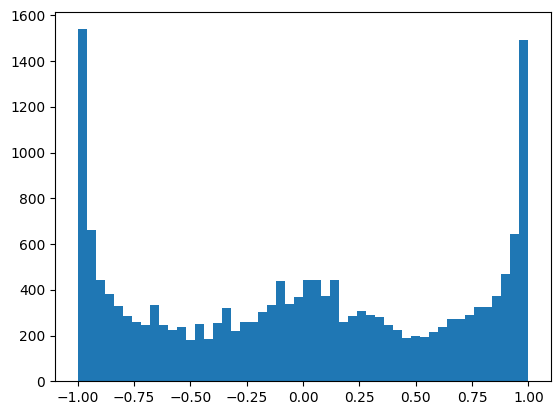

In [268]:
plt.hist(h.view(-1).tolist(),50)

In [269]:
# validation
with torch.no_grad():
    emb = C[XVal]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    hpreact = bngain * (hpreact - bnmean_running) / torch.sqrt(bnstd_running + 1e-5) + bnbais
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    val_loss = F.cross_entropy(logits, YVal)
print("Validation loss:", val_loss.item())

Validation loss: 2.0840117931365967


In [270]:
#sampling
with torch.no_grad():
    for _ in range(20):
        out = []
        Context = [0] * block_size
        while True:
            emb = C[torch.tensor([Context])]
            hpreact = emb.view(1, -1) @ W1 + B1
            hpreact = bngain * (hpreact - bnmean_running) / torch.sqrt(bnstd_running + 1e-5) + bnbais
            h = torch.tanh(hpreact)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            out.append(ix)
            Context = Context[1:] + [ix]
            if ix == 0 or len(out) > 30:
                break
        print("".join(itos[i] for i in out))

dai.
jaion.
sara.
emoni.
ous.
luky.
eldoda.
ansh.
khali.
yaan.
joanna.
aven.
anah.
bulla.
roa.
ashuabeth.
mia.
jeriyah.
magabray.
marven.
